# Random Forest Regressor

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
import seaborn as sns
from sklearn.pipeline import make_pipeline

In [2]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"

NUMBER_SEED = 1

In [3]:
df = pd.read_csv(data)

In [4]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


## Data Preparation

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_displacement  9704 non-null   int64  
 1   num_cylinders        9222 non-null   float64
 2   horsepower           8996 non-null   float64
 3   vehicle_weight       9704 non-null   float64
 4   acceleration         8774 non-null   float64
 5   model_year           9704 non-null   int64  
 6   origin               9704 non-null   object 
 7   fuel_type            9704 non-null   object 
 8   drivetrain           9704 non-null   object 
 9   num_doors            9202 non-null   float64
 10  fuel_efficiency_mpg  9704 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 834.1+ KB


In [7]:
# check for missing values
df.isna().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [8]:
# fill na with median
df['num_cylinders'] = df['num_cylinders'].fillna(df['num_cylinders'].median())
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())
df['acceleration'] = df['acceleration'].fillna(df['acceleration'].median())
df['num_doors'] = df['num_doors'].fillna(df['num_doors'].median())

## Split Data

In [9]:
# split data into train, val and test 60%, 20%, 20%

# test size 20%
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=NUMBER_SEED)

# val 25% of the remaining 80% = 20%
# train is remaining 60%
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=NUMBER_SEED)

In [10]:
# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
# separate target value and remove it from dataframes
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [12]:
# vectorize dataframes
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

In [29]:

def train_rf(xt, yt, max_depth, n_estimators=100, min_sample_leaf=1, print_tree=False):
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                               n_jobs=-1,
                               random_state=NUMBER_SEED)
    rf.fit(xt, yt)

    return rf


In [15]:
arr_max_depth = [1,2,3,4,5, 6, 7, 8]

metric_results = []

for max_depth in arr_max_depth:
    rf = train_rf(X_train, y_train, max_depth)

    y_val_pred = rf.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_val_pred)

    #print('---')
    #print('')

    # Store metrics in dictionary
    metrics = {
        'max_depth': max_depth,
        'rmse': rmse
    }
    metric_results.append(metrics)

    #break


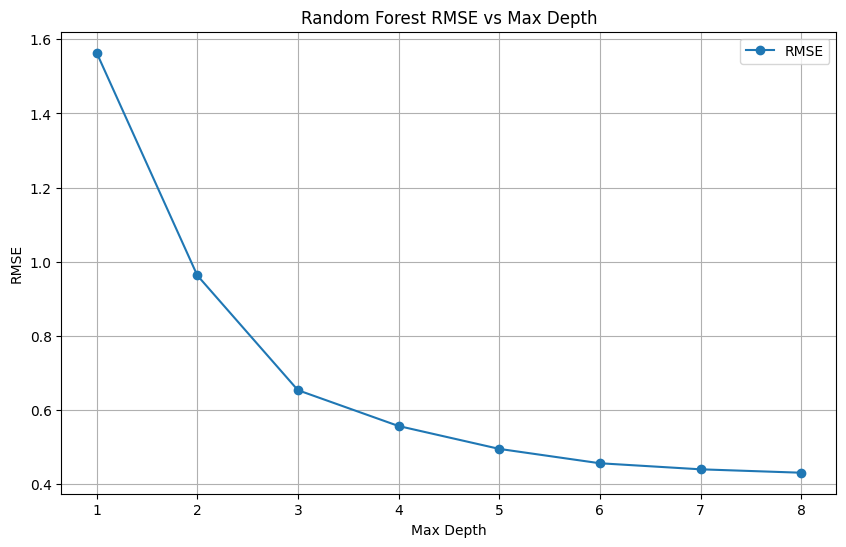

In [16]:
# plot metrics result
df_metrics = pd.DataFrame(metric_results)
plt.figure(figsize=(10, 6))
plt.plot(df_metrics['max_depth'], df_metrics['rmse'], marker='o', label='RMSE')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('Random Forest RMSE vs Max Depth')
plt.legend()
plt.grid()
plt.show()

Try combination parameter max_depth and n_estimators

In [35]:
scores = []

for max_depth in [2, 3, 4, 5, 6, 7, 8]:
    for s in [100, 200, 500, 1000]:
        rf = train_rf(X_train, y_train, max_depth, n_estimators=s)
        y_val_pred = rf.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_val_pred)

        scores.append((max_depth, s, rmse))

In [36]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

In [37]:
df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['rmse'])
#df_scores_pivot.round(3)

In [38]:
df_scores

,max_depth,n_estimators,rmse
0,2,100,0.962859
1,2,200,0.969625
2,2,500,0.967999
3,2,1000,0.964980
4,3,100,0.652918
5,3,200,0.655273
6,3,500,0.653734
7,3,1000,0.652494
8,4,100,0.556178
9,4,200,0.556540


In [39]:
df_scores_pivot

rmse                                                    \
max_depth            2         3         4         5         6         7   
n_estimators                                                               
100           0.962859  0.652918  0.556178  0.494433  0.455653  0.439318   
200           0.969625  0.655273  0.556540  0.495010  0.455943  0.438741   
500           0.967999  0.653734  0.555762  0.494283  0.455750  0.438345   
1000          0.964980  0.652494  0.555408  0.493666  0.455227  0.437755   

                        
max_depth            8  
n_estimators            
100           0.430112  
200           0.429562  
500           0.429434  
1000          0.429247

<Axes: xlabel='None-max_depth', ylabel='n_estimators'>

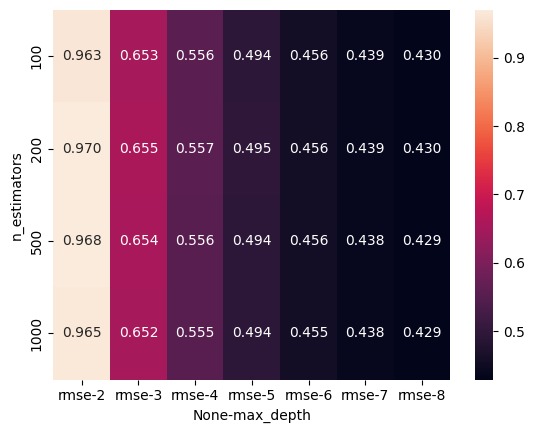

In [41]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

Base on the heatmap, choose max_depth=8 and n_estimators=500, it give lowest rmse 0.429

## Cross validation with kfold

In [42]:
# combine train + val
#X_full_train = np.vstack([X_train, X_val])
y_full_train = np.concatenate([y_train, y_val])

In [43]:
# do cross validation

param_grid = [
    {'max_depth': 8, 'n_estimators': 500},
    {'max_depth': 8, 'n_estimators': 100},
    {'max_depth': 7, 'n_estimators': 500},
    {'max_depth': 6, 'n_estimators': 1000},
]

# Rebuild full-train raw dicts so the DictVectorizer can be fit inside each fold
df_full_train_raw = pd.concat([df_train, df_val], ignore_index=True)
X_full_train_dict = df_full_train_raw.to_dict(orient='records')

result_rmse = []

for p in param_grid:
    #print(p)

    pipe = make_pipeline(
        DictVectorizer(sparse=False),
        RandomForestRegressor(max_depth=p['max_depth'], n_estimators=p['n_estimators'], 
                              n_jobs=-1,
                              random_state=NUMBER_SEED)
    )

    cv = KFold(n_splits=5, shuffle=True, random_state=NUMBER_SEED)
    rmse = cross_val_score(pipe, X_full_train_dict, y_full_train, cv=cv, scoring='neg_root_mean_squared_error')
    # Convert to positive RMSE values
    rmse = -rmse
    rmse_mean = rmse.mean()
    rmse_std = rmse.std()
    result_rmse.append((p['max_depth'], p['n_estimators'], rmse_mean, rmse_std))




In [45]:
# Print result_rmse in a table format
df_result_rmse = pd.DataFrame(result_rmse, columns=['max_depth', 'n_estimators', 'rmse_mean', 'rmse_std'])
print(df_result_rmse)

   max_depth  n_estimators  rmse_mean  rmse_std
0          8           500   0.426661  0.009005
1          8           100   0.427584  0.009290
2          7           500   0.438090  0.010049
3          6          1000   0.460488  0.010044


From cross validation result, it confirm that option max_depth=8 and n_estimators=500, have the lowest mean.



## Train final model

Train final model with train+val dataset, using parameter max_depth=8 and n_estimators=500.

And do prediction using test dataset.

In [46]:
# Final model using the same pipeline approach
final_pipe = make_pipeline(
    DictVectorizer(sparse=False),
    RandomForestRegressor(max_depth=8, n_estimators=500, random_state=NUMBER_SEED)
)

df_full_train_raw = pd.concat([df_train, df_val], ignore_index=True)
X_full_train_dict = df_full_train_raw.to_dict(orient='records')

final_pipe.fit(X_full_train_dict, y_full_train)


Pipeline(steps=[('dictvectorizer', DictVectorizer(sparse=False)),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=8, n_estimators=500,
                                       random_state=1))])

In [47]:
# Predict on test
X_test_dict = df_test.to_dict(orient='records')
y_test_pred = final_pipe.predict(X_test_dict)
rmse_test = root_mean_squared_error(y_test, y_test_pred)
print("rmse test", rmse_test)

rmse test 0.42412866933281756


Get top 10 Feature Importance

In [48]:
# Extract feature names and importances from the fitted pipeline
dv_final = final_pipe.named_steps['dictvectorizer']
tree_final = final_pipe.named_steps['randomforestregressor']

df_fi = pd.DataFrame({
    'feature': dv_final.get_feature_names_out(),
    'importance': tree_final.feature_importances_
}).sort_values(by='importance', ascending=False)

# Top 10
df_fi.head(10)


,feature,importance
13,vehicle_weight,0.976585
6,horsepower,0.013129
0,acceleration,0.008775
7,model_year,0.000420
3,engine_displacement,0.000406
8,num_cylinders,0.000247
9,num_doors,0.000206
11,origin=Europe,0.000058
12,origin=USA,0.000044
10,origin=Asia,0.000043


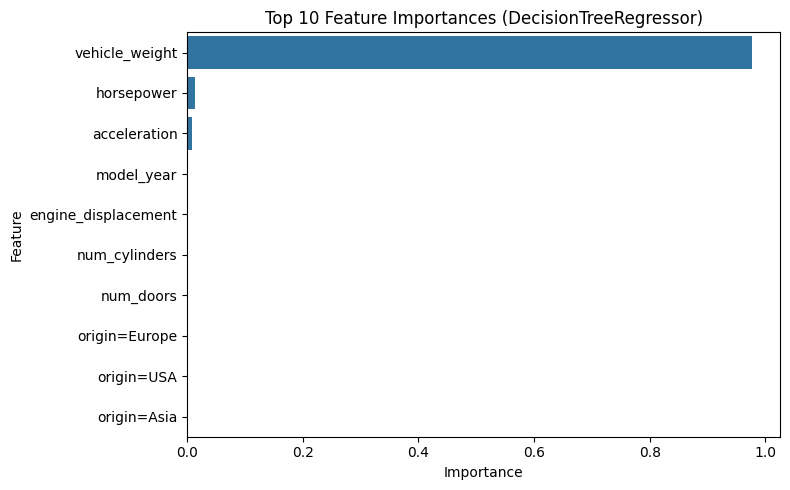

In [49]:
top_n = 10
plt.figure(figsize=(8, 5))
sns.barplot(data=df_fi.head(top_n), x='importance', y='feature', orient='h')
plt.title(f'Top {top_n} Feature Importances (DecisionTreeRegressor)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()